<a href="https://colab.research.google.com/github/aliakbarbadri/natural-language-inference/blob/master/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import tensorflow_addons as tfa

import unicodedata
import re
import numpy as np
import os
import io
import time
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

Using TensorFlow backend.


# Load and Preprocess the data

In [27]:
source = pd.read_pickle(r'https://github.com/aliakbarbadri/natural-language-inference/blob/master/premises_train.pickle?raw=true')
target = pd.read_pickle(r'https://github.com/aliakbarbadri/natural-language-inference/blob/master/hypotheses_train.pickle?raw=true')

In [28]:
print(source[0])
print(target[0])

A person on a horse jumps over a broken down airplane .
A person is outdoors , on a horse .


In [29]:
lines_main = pd.DataFrame(
    {'source': source,
     'target': target
     })

In [30]:
lines_main.shape

(183416, 2)

In [31]:
lines = lines_main[:50000]

In [32]:
lines.shape

(50000, 2)

In [33]:
# Lowercase all characters
lines.source=lines.source.apply(lambda x: x.lower())
lines.target=lines.target.apply(lambda x: x.lower())

# Remove quotes
lines.source=lines.source.apply(lambda x: re.sub("'", '', x))
lines.target=lines.target.apply(lambda x: re.sub("'", '', x))

exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines.source=lines.source.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.target=lines.target.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.source=lines.source.apply(lambda x: x.translate(remove_digits))
lines.target=lines.target.apply(lambda x: x.translate(remove_digits))

# Remove extra spaces
lines.source=lines.source.apply(lambda x: x.strip())
lines.target=lines.target.apply(lambda x: x.strip())
lines.source=lines.source.apply(lambda x: re.sub(" +", " ", x))
lines.target=lines.target.apply(lambda x: re.sub(" +", " ", x))

# Add start and end tokens to target sequences
lines.target = lines.target.apply(lambda x : 'START_ '+ x + ' _END')

lines.sample(10)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,source,target
37043,in a crowd of people a man stands smiling with...,START_ a group of people are standing _END
37118,three young women are leaning on a railing ove...,START_ people are leaning against a railing _END
215,a group of people are doing yoga,START_ the people are doing yoga _END
10376,a man in a blue shirt is speaking into a megap...,START_ a man is wearing a shirt _END
15273,a woman in a white coat is standing next to a ...,START_ a person in a white coat is standing ne...
8483,one man throws a flying kick at another man,START_ two men are fighting _END
19383,an african american woman who seems to be sell...,START_ a woman is selling health food _END
3111,the two hockey players are down on the ice,START_ the players are on the ice _END
42636,a man with a dog holding a leash and a small bag,START_ a man is walking a dog _END
31199,a black dog and a dog that is brown and white ...,START_ two dogs are in the water _END


In [34]:
all_words_source=set()
for line in lines.source:
    for word in line.split():
        if word not in all_words_source:
            all_words_source.add(word)

all_words_target=set()
for line in lines.target:
    for word in line.split():
        if word not in all_words_target:
            all_words_target.add(word)

In [35]:
lenght_list=[]
for l in lines.source:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)

lenght_list=[]
for l in lines.target:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)

max_length_src, max_length_tar

(78, 45)

In [36]:
input_words = sorted(list(all_words_source))
target_words = sorted(list(all_words_target))

num_encoder_tokens = len(all_words_source)#+1
num_decoder_tokens = len(all_words_target)+1

num_encoder_tokens, num_decoder_tokens

(11410, 8694)

In [37]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [38]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [39]:
# lines = shuffle(lines)
lines.head(10)

,source,target
0,a person on a horse jumps over a broken down a...,START_ a person is outdoors on a horse _END
1,children smiling and waving at camera,START_ there are children present _END
2,a boy is jumping on skateboard in the middle o...,START_ the boy does a skateboarding trick _END
3,two blond women are hugging one another,START_ there are women showing affection _END
4,a few people in a restaurant setting one of th...,START_ the diners are at a restaurant _END
5,an older man is drinking orange juice at a res...,START_ a man is drinking juice _END
6,a man with blondhair and a brown shirt drinkin...,START_ a blond man drinking water from a fount...
7,two women who just had lunch hugging and sayin...,START_ there are two woman in this picture _END
8,two women holding food carryout containers hug,START_ two women hug each other _END
9,a little league team tries to catch a runner s...,START_ a team is trying to tag a runner out _END


In [40]:
# Train - Test Split
X, y = lines.source, lines.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, X_test.shape

((40000,), (10000,))

In [41]:
# X_train.to_pickle('X_train.pkl')
# X_test.to_pickle('X_test.pkl')

In [42]:
def generate_batch(X = X_train, y = y_train, batch_size = 64):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

# Model

In [43]:
latent_dim = 256

In [44]:
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(1024, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

In [55]:
decoder_inputs = Input(shape=(None,))
# dec_emb = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)(decoder_inputs)
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(1024, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [46]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2920960     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 256)    2225664     input_4[0][0]                    
____________________________________________________________________________________________

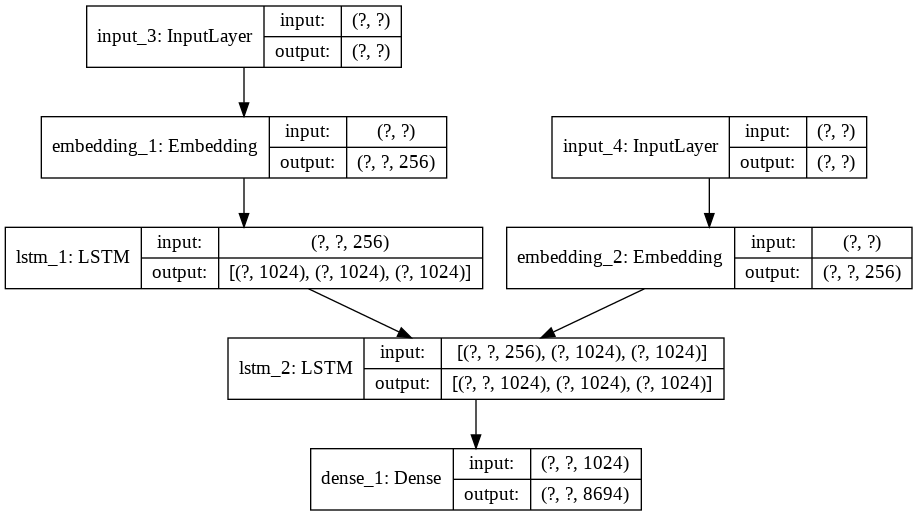

In [47]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [48]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 32
epochs = 7

In [49]:
history = model.fit(generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
1250/1250 [==============================] - 911s 729ms/step - loss: 0.6329 - acc: 0.3781 - val_loss: 0.5285 - val_acc: 0.4273
Epoch 2/10
1250/1250 [==============================] - 922s 737ms/step - loss: 0.5456 - acc: 0.4397 - val_loss: 0.5811 - val_acc: 0.4465
Epoch 3/10
1250/1250 [==============================] - 933s 746ms/step - loss: 0.5063 - acc: 0.4616 - val_loss: 0.5384 - val_acc: 0.4602
Epoch 4/10
1250/1250 [==============================] - 949s 759ms/step - loss: 0.4661 - acc: 0.4867 - val_loss: 0.5373 - val_acc: 0.4708
Epoch 5/10
1250/1250 [==============================] - 929s 743ms/step - loss: 0.4256 - acc: 0.5146 - val_loss: 0.5056 - val_acc: 0.4716
Epoch 6/10
1250/1250 [==============================] - 934s 747ms/step - loss: 0.3869 - acc: 0.5465 - val_loss: 0.5930 - val_acc: 0.4663
Epoch 7/10
1250/1250 [==============================] - 933s 746ms/step - loss: 0.3509 - acc: 0.5813 - val_loss: 0.4922 - val_acc: 0.4639
Epoch 8/10
1250/1250 [============

In [ ]:
model = keras.models.load_model('seq2seq_model.h5')

# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model.h5")
# print("Saved model to disk")

In [50]:
model.save('seq2seq_model.h5')

# load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()

# Loss and Acc. graph

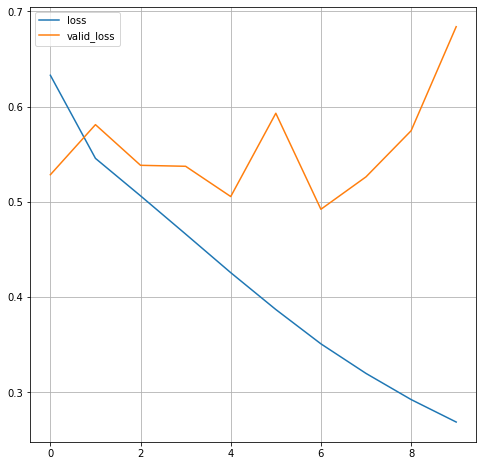

In [51]:
pd.DataFrame({'loss':history.history['loss'],
              'valid_loss':history.history['val_loss'],
              }).plot(figsize=(8, 8))
plt.grid(True)

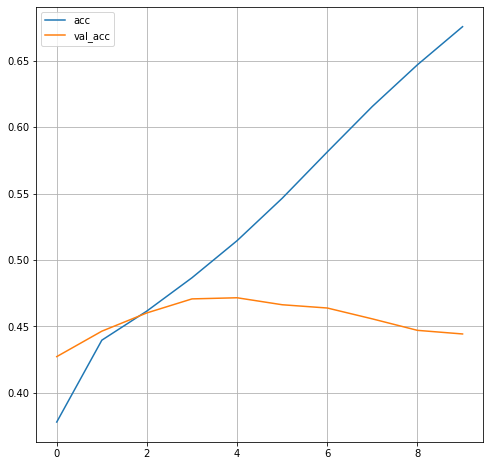

In [52]:
pd.DataFrame({'acc':history.history['acc'],
              'val_acc':history.history['val_acc']
              }).plot(figsize=(8, 8))
plt.grid(True)


# Model Evaluation

In [56]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs2] + decoder_states2)

ValueError: ignored

In [54]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_token_index['START_']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return decoded_sentence

In [ ]:
test_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [ ]:
for k in range(X_test.shape[0])
k+=1
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input:', X_test[k:k+1].values[0])
print('Actual:', y_test[k:k+1].values[0][6:-4])
print('Predicted:', decoded_sentence[:-4])

Input: a man is getting help with fitness
Actual:  a man getting help with fitness from a physical trainer in a gym 
Predicted:  a man in a white shirt is working on a stage 


In [ ]:
# just to see why use 6, -4
print(y_test[k:k+1].values[0]))
print(y_test[k:k+1].values[0][6:-4])
print()
print(decoded_sentence)
print(decoded_sentence[:-4])

START_ a man getting help with fitness from a physical trainer in a gym _END
 a man getting help with fitness from a physical trainer in a gym 

 a man in a white shirt is working on a stage _END
 a man in a white shirt is working on a stage 


# Blue

In [ ]:
list_of_references = []
list_of_hypotheses = []
for k in range(val_samples)
  (input_seq, actual_output), _ = next(test_gen)
  decoded_sentence = decode_sequence(input_seq)

  list_of_hypotheses.append(y_test[k:k+1].values[0][6:-4].split())
  list_of_references.append([decoded_sentence[:-4].split()])
  print('Input:', X_test[k:k+1].values[0])
  print('Actual:', y_test[k:k+1].values[0][6:-4])
  print('Predicted:', decoded_sentence[:-4])


https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213

In [ ]:
list_of_references = [[ref1a, ref1b, ref1c], [ref2a]]
>>> hypotheses = [hyp1, hyp2]
>>> corpus_bleu(list_of_references, hypotheses) 
0.5920...

# first 30 of test 

In [ ]:
for i in range(30):
  print(i)
  print(list_of_references[i][0])
  print(list_of_hypotheses[i])
  print("---------------------")